# Audio MNIST

* **Dataset**: https://www.kaggle.com/datasets/sripaadsrinivasan/audio-mnist/code

In [2]:
import io 
import os
import wave
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.utils import load_img, img_to_array, image_dataset_from_directory

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [4]:
def generate_spectrograms(
   data_dir: str = "../datasets/audio-mnist/data",
   output_dir: str = "../datasets/audio-mnist/images",
   num_train: int = 5000,
   num_test: int = 500
) -> None:
   """Generate fixed number of spectrograms for train/test."""
   os.makedirs(output_dir, exist_ok=True)
   train_dir = os.path.join(output_dir, "train")
   test_dir = os.path.join(output_dir, "test") 
   
   for split_dir in [train_dir, test_dir]:
       os.makedirs(split_dir, exist_ok=True)

   train_count = 0
   test_count = 0
       
   for dir_name in os.listdir(data_dir):
       current_dir = os.path.join(data_dir, dir_name)
       if not os.path.isdir(current_dir):
           continue
           
       for file in os.listdir(current_dir):
           if not file.endswith('.wav'):
               continue

           if train_count < num_train:
               output_base = train_dir
               train_count += 1
           elif test_count < num_test:
               output_base = test_dir 
               test_count += 1
           else:
               return

           number = file.split("_")[0]
           output_dir = os.path.join(output_base, number)
           os.makedirs(output_dir, exist_ok=True)
           
           with wave.open(os.path.join(current_dir, file), 'r') as f:
               fs = f.getframerate()
               wavebytes = np.frombuffer(f.readframes(-1), 'int16')
               
               plt.figure(figsize=(4, 4), dpi=100)
               plt.axis('off')
               plt.specgram(wavebytes, NFFT=256, Fs=fs)
               plt.savefig(
                   os.path.join(output_dir, file.replace(".wav", ".png")),
                   bbox_inches='tight', 
                   pad_inches=0
               )
               plt.close()

In [5]:
generate_spectrograms()

In [7]:
base_path = '../datasets/audio-mnist/images/'
img_shape = (369, 496)

train = image_dataset_from_directory(os.path.join(base_path, "train"), image_size = img_shape)
test = image_dataset_from_directory(os.path.join(base_path, "test"), image_size = img_shape)

Found 5000 files belonging to 10 classes.
Found 500 files belonging to 10 classes.


2025-01-09 12:54:31.045175: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


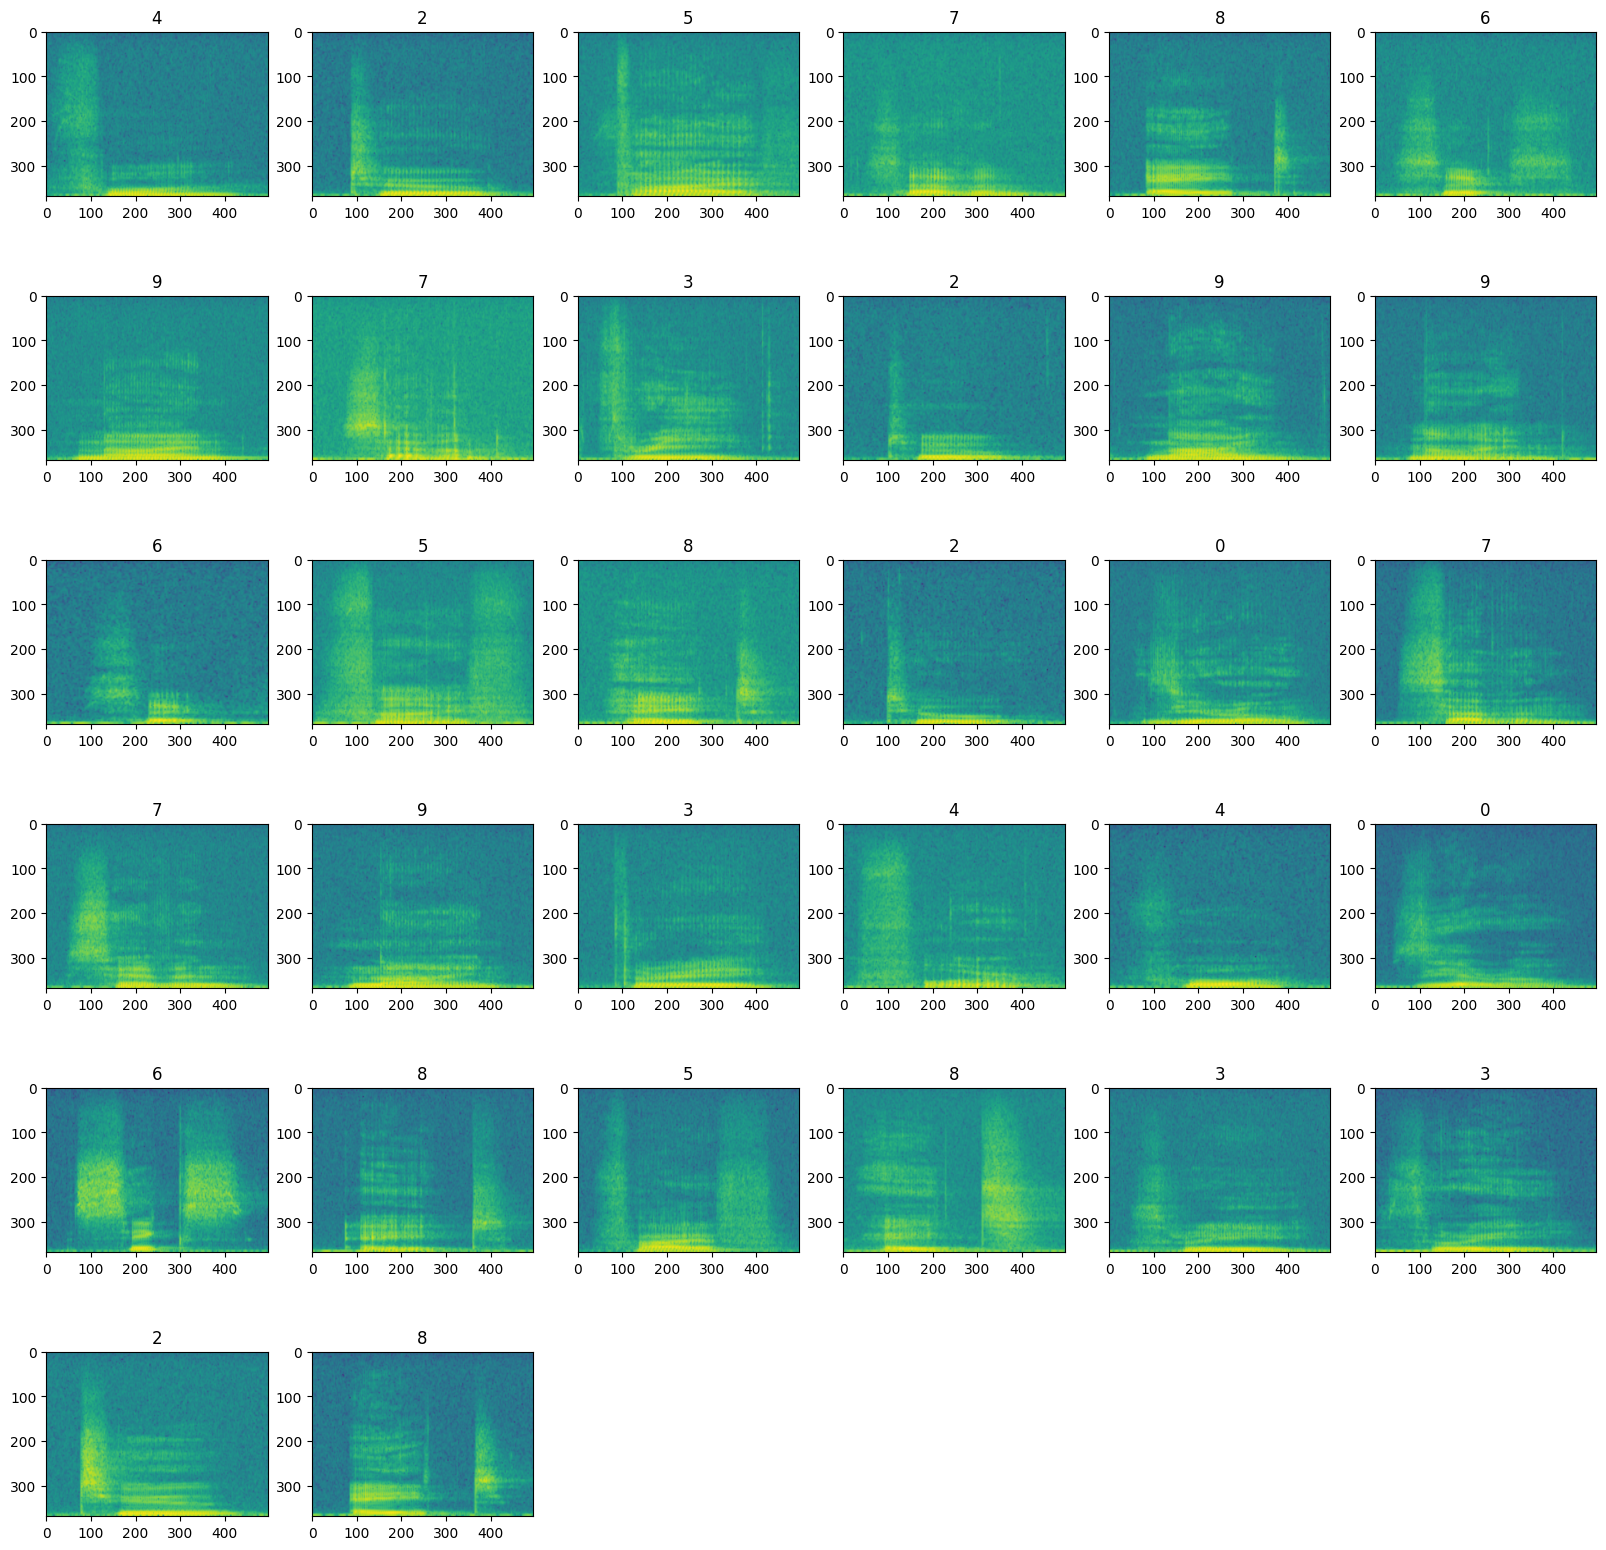

In [9]:
plt.figure(figsize=(20, 20))
for images, labels in train.take(1):
    for i in range(0, 32):
        ax = plt.subplot(6, 6, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(train.class_names[labels[i]])

In [19]:
def build_cnn_model(input_shape=(369, 496, 3), n_classes=10):
    model = Sequential([
        # First conv block
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((3, 3)),
        
        # Second conv block - increased filters
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((3, 3)),
        
        # Third conv block - further increased filters
        Conv2D(100, (3, 3), activation='relu'),
        MaxPooling2D((3, 3)),
        
        Flatten(),
        
        # Dense layers with dropout
        Dense(100, activation='relu'),
        Dropout(0.2),
        Dense(100, activation='relu'),
        Dropout(0.2),
        Dense(n_classes, activation='softmax')
    ])
    
    return model

In [23]:
model = build_cnn_model()
model.compile(loss='sparse_categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 367, 494, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 122, 164, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 120, 162, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 40, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 38, 52, 100)    │        57,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 12, 17, 100)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 20400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 100)            │     2,040,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,128,302 (8.12 MB)

 Trainable params: 2,128,302 (8.12 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
result = model.fit(train, validation_data=test, epochs=15)

Epoch 1/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 248s 2s/step - accuracy: 0.3237 - loss: 8.3548 - val_accuracy: 0.7660 - val_loss: 0.7320
Epoch 2/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 265s 2s/step - accuracy: 0.7730 - loss: 0.7446 - val_accuracy: 0.8420 - val_loss: 0.5343
Epoch 3/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 249s 2s/step - accuracy: 0.8526 - loss: 0.4957 - val_accuracy: 0.7300 - val_loss: 1.0122
Epoch 4/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 247s 2s/step - accuracy: 0.8767 - loss: 0.3709 - val_accuracy: 0.8400 - val_loss: 0.4673
Epoch 5/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 246s 2s/step - accuracy: 0.9039 - loss: 0.3126 - val_accuracy: 0.7760 - val_loss: 0.9265
Epoch 6/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 245s 2s/step - accuracy: 0.9308 - loss: 0.2322 - val_accuracy: 0.7940 - val_loss: 0.7575
Epoch 7/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 244s 2s/step - accuracy: 0.9484 - loss: 0.1756 - val_accuracy: 0.7900 - val_loss: 0.8712
Epoch 8/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 243s 2s/step - accuracy: 0.9593 - loss: 0.1519 - val_accu

In [25]:
def plot_training_history(history, metric='accuracy', figsize=(10, 6)):
   plt.figure(figsize=figsize)
   
   plt.plot(history.history[metric], label='train')
   plt.plot(history.history[f'val_{metric}'], label='validation')
   
   plt.title(f'Model {metric}')
   plt.xlabel('Epoch')
   plt.ylabel(metric.capitalize())
   plt.legend(loc='upper left')
   plt.tight_layout()
   
   return plt.gcf()

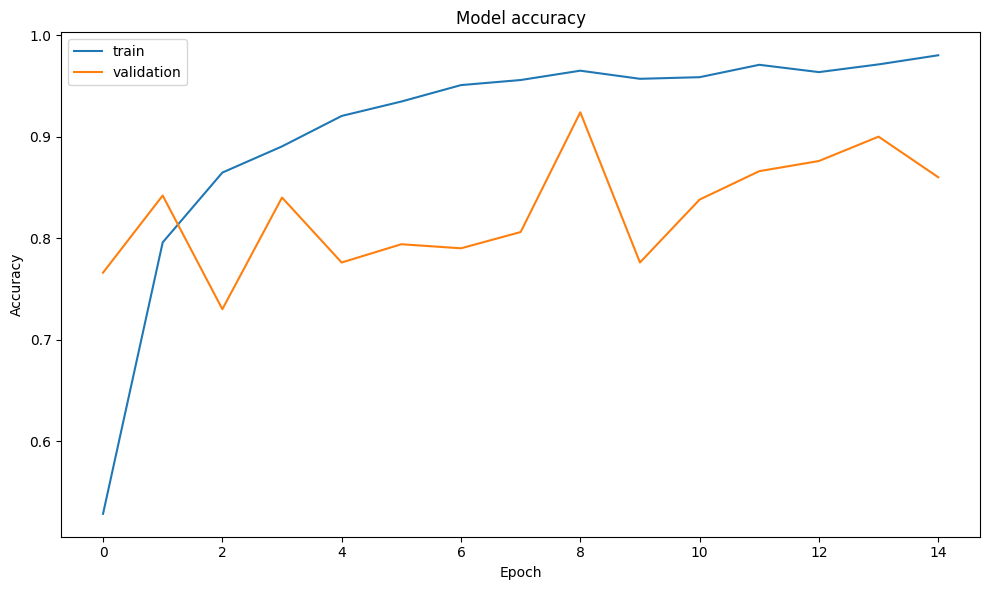

In [26]:
plot_training_history(result)
plt.show()

In [27]:
def predict_audio_digit(audio_file_path, model):
  """Predicts the digit in an audio file.

  Args:
      audio_file_path: Path to the .wav audio file.
      model: The trained Keras model.

  Returns:
      The predicted digit as an integer.
  """

  with wave.open(audio_file_path, 'r') as f:
      fs = f.getframerate()
      wavebytes = np.frombuffer(f.readframes(-1), 'int16')

      plt.figure(figsize=(4, 4), dpi=100)
      plt.axis('off')
      plt.specgram(wavebytes, NFFT=256, Fs=fs)
      # Save to a temporary image file
      temp_image_path = "temp_spectrogram.png"
      plt.savefig(temp_image_path, bbox_inches='tight', pad_inches=0)
      plt.close()

  img = load_img(temp_image_path, target_size=(369, 496))
  img_array = img_to_array(img)
  img_array = np.expand_dims(img_array, axis=0)

  predictions = model.predict(img_array)
  predicted_class = np.argmax(predictions[0])

  os.remove(temp_image_path)

  return predicted_class

In [30]:
predicted_digit = predict_audio_digit("../audio/6.wav", model)
print(f"The predicted digit is: {predicted_digit}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
The predicted digit is: 6


In [31]:
predicted_digit = predict_audio_digit("../audio/4.wav", model)
print(f"The predicted digit is: {predicted_digit}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
The predicted digit is: 4
